In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

/home/rahovegas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/rahovegas/.cache/kagglehub/datasets/moltean/fruits/versions/11


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

In [3]:
def getYourFruits(directory_path, fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = f"{directory_path}/*/fruits-360/" + data_type + "/"
        for i,f in enumerate(fruits):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = f"{directory_path}/*/fruits-360/" + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits(directory_path):
    fruits = []
    for fruit_path in glob.glob(f"{directory_path}/*/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

In [4]:
fruits = getAllFruits(path)
fruits = np.unique(fruits)
print(fruits)

train_imgs, train_labels = getYourFruits(path, fruits, "Training", print_n=True)

test_imgs, test_labels = getYourFruits(path, fruits, "Test", print_n=True)

print(len(train_imgs), len(train_labels), len(test_imgs), len(test_labels))

['Apple 6' 'Apple Braeburn 1' 'Apple Crimson Snow 1' 'Apple Golden 1'
 'Apple Golden 2' 'Apple Golden 3' 'Apple Granny Smith 1'
 'Apple Pink Lady 1' 'Apple Red 1' 'Apple Red 2' 'Apple Red 3'
 'Apple Red Delicious 1' 'Apple Red Yellow 1' 'Apple Red Yellow 2'
 'Apple hit 1' 'Apricot 1' 'Avocado 1' 'Avocado ripe 1' 'Banana 1'
 'Banana Lady Finger 1' 'Banana Red 1' 'Beetroot 1' 'Blueberry 1'
 'Cabbage white 1' 'Cactus fruit 1' 'Cantaloupe 1' 'Cantaloupe 2'
 'Carambula 1' 'Carrot 1' 'Cauliflower 1' 'Cherry 1' 'Cherry 2'
 'Cherry Rainier 1' 'Cherry Wax Black 1' 'Cherry Wax Red 1'
 'Cherry Wax Yellow 1' 'Chestnut 1' 'Clementine 1' 'Cocos 1' 'Corn 1'
 'Corn Husk 1' 'Cucumber 1' 'Cucumber 3' 'Cucumber Ripe 1'
 'Cucumber Ripe 2' 'Dates 1' 'Eggplant 1' 'Eggplant long 1' 'Fig 1'
 'Ginger Root 1' 'Granadilla 1' 'Grape Blue 1' 'Grape Pink 1'
 'Grape White 1' 'Grape White 2' 'Grape White 3' 'Grape White 4'
 'Grapefruit Pink 1' 'Grapefruit White 1' 'Guava 1' 'Hazelnut 1'
 'Huckleberry 1' 'Kaki 1' 'Kiw

In [5]:
def get_top_10_fruits(train_labels):
	unique, counts = np.unique(train_labels, return_counts=True)
	fruits_count = dict(zip(unique, counts))
	fruits_count = dict(sorted(fruits_count.items(), key=lambda item: item[1], reverse=True))
	top_10_fruits = list(fruits_count.keys())[:10]
	return top_10_fruits

Labels:  [ 51 112  31  32  75  88 125 128 130 137]


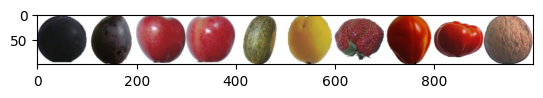

In [6]:
top_10_fruits = get_top_10_fruits(train_labels)
show_idxs = [np.where(train_labels == i)[0][0] for i in top_10_fruits]
show_imgs = np.concatenate(tuple(train_imgs[idx,:,:] for idx in show_idxs), axis=1)
plt.imshow(show_imgs)

print("Labels: ", train_labels[show_idxs])

Total number of classes:  141


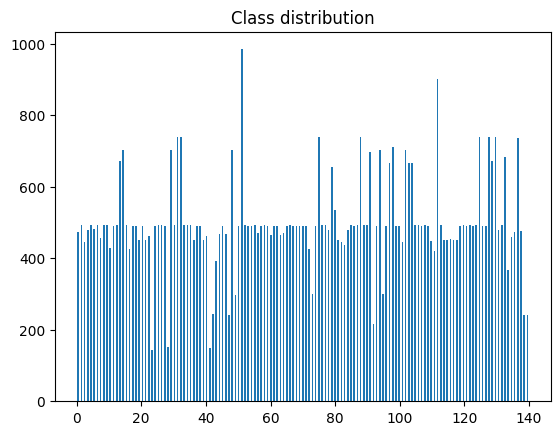

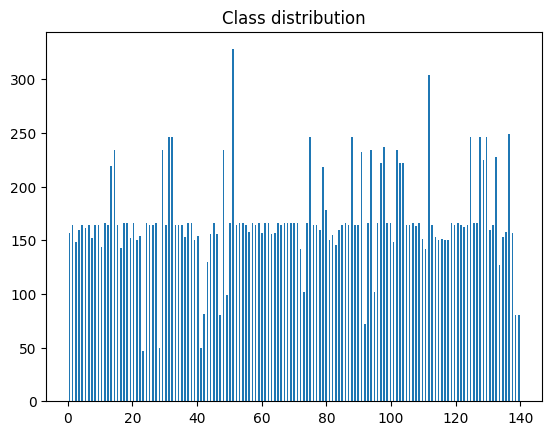

In [7]:
def plot_class_distribution(labels):
	plt.title('Class distribution')
	plt.hist(labels, bins=len(np.unique(labels)), rwidth=0.5)
	plt.show()
	
print("Total number of classes: ", len(np.unique(train_labels)))
plot_class_distribution(train_labels)
plot_class_distribution(test_labels)

In [8]:
class DataProcessing:
	def __init__(self, train_data, test_data):
		self.train_data = train_data
		self.test_data = test_data

	def extract_HOG_features(self, imgs, hog_path, n_bins=9):
		if os.path.exists(hog_path):
			return pickle.load(open(hog_path + '/hog_features.pkl', 'rb'))
		
		os.makedirs(hog_path)

		fds = []

		idx = 0

		for img in imgs:
			img_resized = resize(img, (128, 64))
			fd, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
			hog_img = resize(hog_img, (100, 100))
			
			pickle.dump(hog_img, open(hog_path + '/hog_img_{}.pkl'.format(idx), 'wb'))
			fds.append(fd)

			idx += 1

		pickle.dump(fds, open(hog_path + '/hog_features.pkl', 'wb'))
		
		return np.array(fds)
	
	def show_HOG(self, img, hog_features, n_bins):
		fig = plt.figure(figsize=(5, 5))

		ax1 = fig.add_subplot(1, 2, 1)
		ax1.axis('off')
		ax1.set_title('Original Image')
		plt.imshow(img)

		ax1 = fig.add_subplot(1, 2, 2)
		ax1.axis('off')
		ax1.set_title('HOG')
		scaled_features = resize(hog_features, (100, 100))
		plt.imshow(scaled_features, cmap='gray')

		plt.show()

	def show_HOG_all_classes(self, imgs, n_bins):
		for idx in show_idxs:
			hog_feature = pickle.load(open('./hog_train/hog_img_{}.pkl'.format(idx), 'rb'))
			self.show_HOG(imgs[idx,:,:], hog_feature, n_bins)

	def extract_ORB_features(self, imgs):
		orb = cv2.ORB_create()
		
		orb_kp = []
		orb_des = np.zeros((len(imgs), 32))

		idx = 0

		for img in imgs:
			train_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
			train_kp, train_des = orb.detectAndCompute(train_img, None)

			if train_des is None:
				train_des = np.zeros((1, 32))

			orb_des[idx, :] = np.array([np.mean(train_des, axis=0)])

			idx += 1

			orb_kp.append(train_kp)

		return orb_kp, orb_des

	def show_ORB(self, img, kp):
		kp_without_size = np.copy(img)
		kp_with_size = np.copy(img)

		cv2.drawKeypoints(img, kp, kp_without_size, color=(0, 255, 0))
		cv2.drawKeypoints(img, kp, kp_with_size, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

		fig = plt.figure(figsize=(5, 5))

		ax1 = fig.add_subplot(1, 3, 1)
		ax1.axis('off')
		ax1.set_title('Original Image')
		plt.imshow(img)

		ax1 = fig.add_subplot(1, 3, 2)
		ax1.axis('off')
		ax1.set_title('No size')
		plt.imshow(kp_without_size, cmap='gray')

		ax1 = fig.add_subplot(1, 3, 3)
		ax1.axis('off')
		ax1.set_title('With size')
		plt.imshow(kp_with_size, cmap='gray')

		plt.show()

	def show_ORB_all_classes(self, imgs, ORB_kp):
		for idx in show_idxs:
			self.show_ORB(imgs[idx,:,:], ORB_kp[idx])

	def collect_and_transform_data(self):
		scaler = StandardScaler()

		train_orb_kp, train_orb_des = self.extract_ORB_features(train_imgs)
		self.show_ORB_all_classes(train_imgs, train_orb_kp)

		train_orb_des = train_orb_des.reshape(train_orb_des.shape[0], -1)

		test_orb_kp, test_orb_des = self.extract_ORB_features(test_imgs)
		test_orb_des = test_orb_des.reshape(test_orb_des.shape[0], -1)

		train_hog = self.extract_HOG_features(train_imgs, 'hog_train', 9)
		self.show_HOG_all_classes(train_imgs, 9)

		test_hog = self.extract_HOG_features(test_imgs, 'hog_test', 9)

		X_train = np.concatenate((train_hog, train_orb_des), axis=1)
		X_test = np.concatenate((test_hog, test_orb_des), axis=1)

		print("Number of extracted features after HOG and ORB:", X_train.shape[1])

		sel = VarianceThreshold(threshold=.97 * (1 - .97))
		X_train = sel.fit_transform(X_train)
		X_test = sel.transform(X_test)

		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)

		print("Number of extracted features after variance threshold:", X_train.shape[1])

		return X_train, X_test, train_labels, test_labels

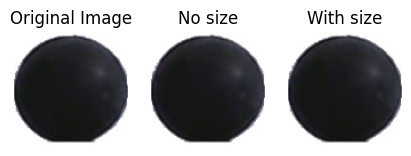

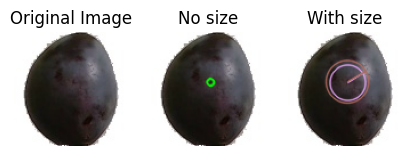

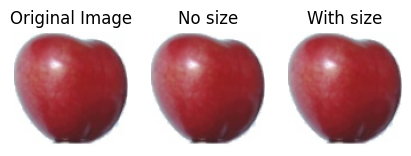

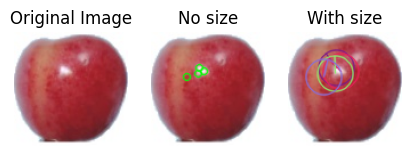

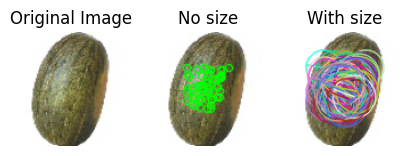

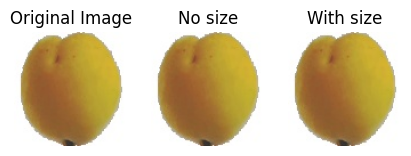

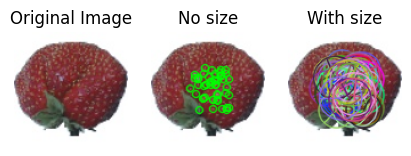

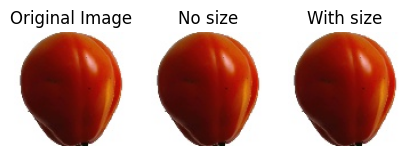

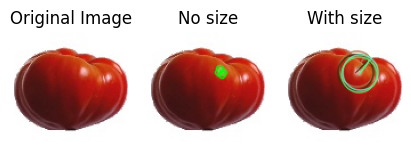

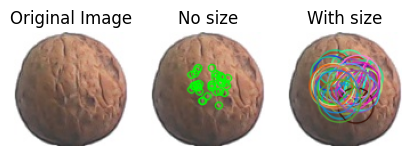

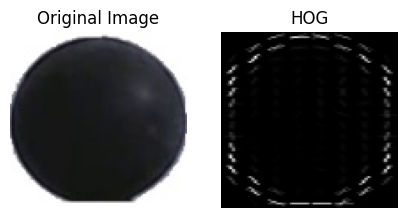

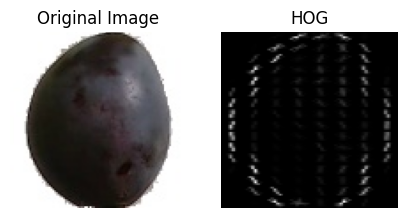

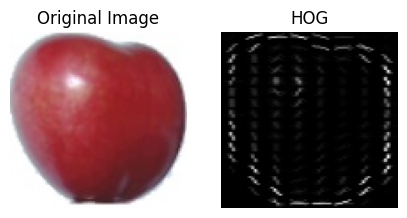

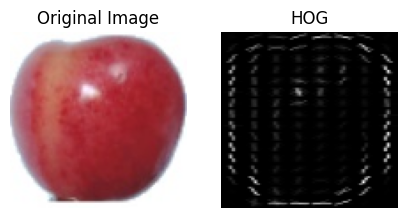

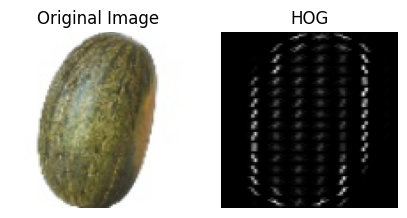

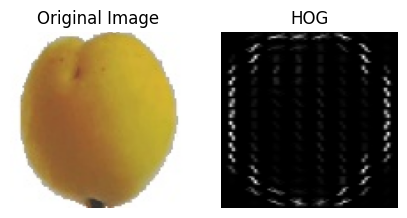

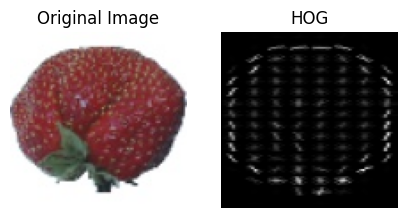

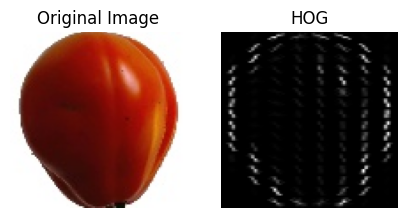

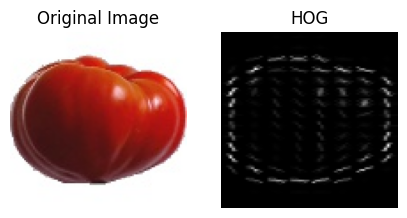

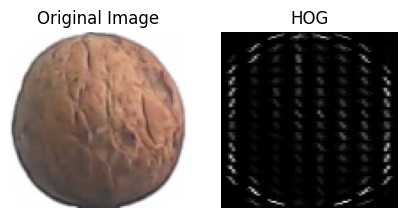

Number of extracted features after HOG and ORB: 3812
Number of extracted features after variance threshold: 286


In [9]:
X_train, X_test, y_train, y_test = DataProcessing(train_imgs, test_imgs).collect_and_transform_data()
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import xgboost as xgb

import seaborn as sns

Statistics for validation set - Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        99
           1       0.98      1.00      0.99       105
           2       0.99      0.99      0.99        94
           3       0.99      1.00      1.00       106
           4       0.98      1.00      0.99        92
           5       1.00      0.97      0.99        80
           6       1.00      1.00      1.00       105
           7       0.96      0.98      0.97        83
           8       0.97      0.98      0.98       106
           9       0.99      0.99      0.99        90
          10       0.96      0.98      0.97        81
          11       1.00      0.97      0.98        95
          12       0.98      0.97      0.98       106
          13       0.97      0.94      0.96       126
          14       0.98      0.98      0.98       144
          15       0.97      1.00      0.98        96
          16       0.96      

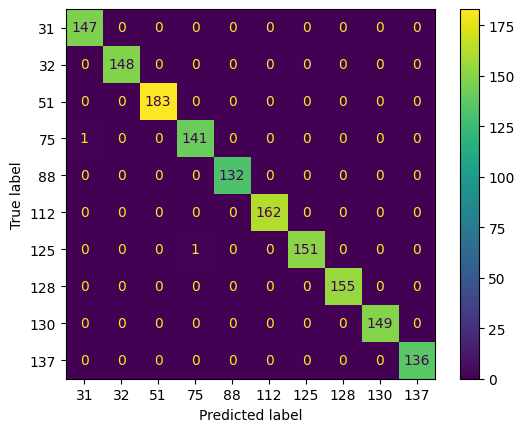

In [11]:
clf_lr = LogisticRegression(penalty='l2', C=0.2, multi_class='multinomial', random_state=0, max_iter=1000).fit(X_train, y_train)
y_pred = clf_lr.predict(X_validate)

print("Statistics for validation set - Logistic Regression")
print(classification_report(y_validate, y_pred))

relevant_validate_idxs = np.where(np.isin(y_validate, top_10_fruits) & np.isin(y_pred, top_10_fruits))[0]
ConfusionMatrixDisplay.from_predictions(y_validate[relevant_validate_idxs], y_pred[relevant_validate_idxs])

Statistics for validation set - SVM
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       1.00      1.00      1.00       105
           2       0.99      1.00      0.99        94
           3       1.00      1.00      1.00       106
           4       0.99      1.00      0.99        92
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00       105
           7       0.99      1.00      0.99        83
           8       1.00      1.00      1.00       106
           9       1.00      1.00      1.00        90
          10       1.00      1.00      1.00        81
          11       1.00      0.99      0.99        95
          12       1.00      1.00      1.00       106
          13       1.00      0.98      0.99       126
          14       0.99      1.00      1.00       144
          15       0.99      1.00      0.99        96
          16       1.00      1.00      1.00  

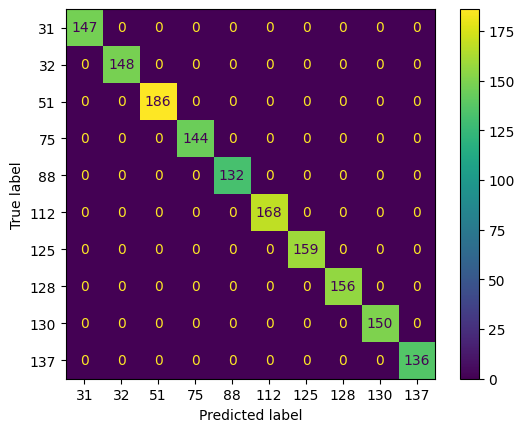

In [12]:
clf_svm = SVC(C=0.2, kernel='linear', gamma='auto', random_state=0).fit(X_train, y_train)
y_pred = clf_svm.predict(X_validate)

print("Statistics for validation set - SVM")
print(classification_report(y_validate, y_pred))

relevant_validate_idxs = np.where(np.isin(y_validate, top_10_fruits) & np.isin(y_pred, top_10_fruits))[0]
ConfusionMatrixDisplay.from_predictions(y_validate[relevant_validate_idxs], y_pred[relevant_validate_idxs])

Statistics for validation set - Random Forest
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        99
           1       0.94      0.96      0.95       105
           2       0.98      0.98      0.98        94
           3       0.94      1.00      0.97       106
           4       0.96      1.00      0.98        92
           5       0.94      0.95      0.94        80
           6       0.98      0.99      0.99       105
           7       0.99      0.98      0.98        83
           8       0.99      0.98      0.99       106
           9       0.93      0.97      0.95        90
          10       0.94      0.98      0.96        81
          11       0.97      0.94      0.95        95
          12       0.98      0.99      0.99       106
          13       0.97      0.99      0.98       126
          14       0.94      0.99      0.96       144
          15       0.91      0.92      0.91        96
          16       0.99      0.92  

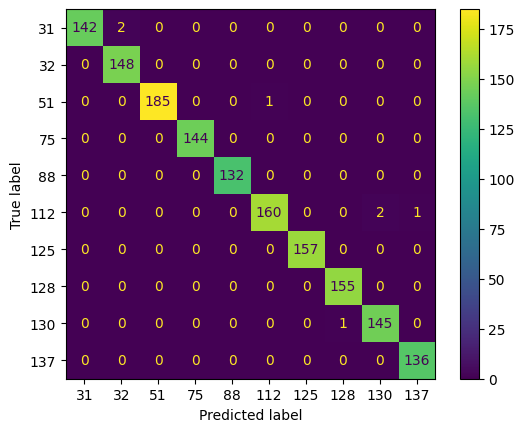

In [13]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, max_samples=10000, bootstrap=True).fit(X_train, y_train)
y_pred = clf_rf.predict(X_validate)

print("Statistics for validation set - Random Forest")
print(classification_report(y_validate, y_pred))

relevant_validate_idxs = np.where(np.isin(y_validate, top_10_fruits) & np.isin(y_pred, top_10_fruits))[0]
ConfusionMatrixDisplay.from_predictions(y_validate[relevant_validate_idxs], y_pred[relevant_validate_idxs])

Statistics for validation set - XGBoost
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        99
           1       0.97      0.94      0.96       105
           2       0.97      0.95      0.96        94
           3       0.92      0.98      0.95       106
           4       0.96      1.00      0.98        92
           5       0.95      0.94      0.94        80
           6       0.94      0.94      0.94       105
           7       0.95      1.00      0.98        83
           8       0.99      0.98      0.99       106
           9       0.86      0.96      0.91        90
          10       0.92      0.94      0.93        81
          11       0.97      0.91      0.93        95
          12       0.96      0.94      0.95       106
          13       0.92      0.94      0.93       126
          14       0.92      0.97      0.94       144
          15       0.90      0.95      0.92        96
          16       0.97      0.94      0.

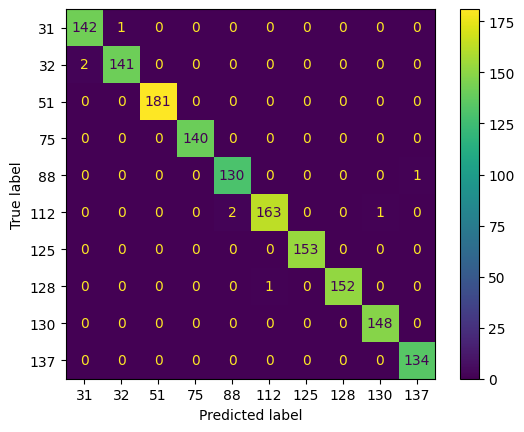

In [14]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.01, random_state=0).fit(X_train, y_train)
y_pred = clf_xgb.predict(X_validate)

print("Statistics for validation set - XGBoost")
print(classification_report(y_validate, y_pred))

relevant_validate_idxs = np.where(np.isin(y_validate, top_10_fruits) & np.isin(y_pred, top_10_fruits))[0]
ConfusionMatrixDisplay.from_predictions(y_validate[relevant_validate_idxs], y_pred[relevant_validate_idxs])

Statistics for test set - Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       157
           1       0.69      0.70      0.69       164
           2       0.67      0.91      0.77       148
           3       0.83      0.85      0.84       160
           4       0.78      0.73      0.75       164
           5       0.69      0.61      0.65       161
           6       0.91      0.78      0.84       164
           7       0.54      0.64      0.59       152
           8       0.64      0.69      0.66       164
           9       0.62      0.61      0.62       164
          10       0.74      0.76      0.75       144
          11       0.81      0.76      0.78       166
          12       0.63      0.74      0.68       164
          13       0.59      0.64      0.61       219
          14       0.78      0.98      0.87       234
          15       0.85      0.66      0.75       164
          16       0.68      0.71  

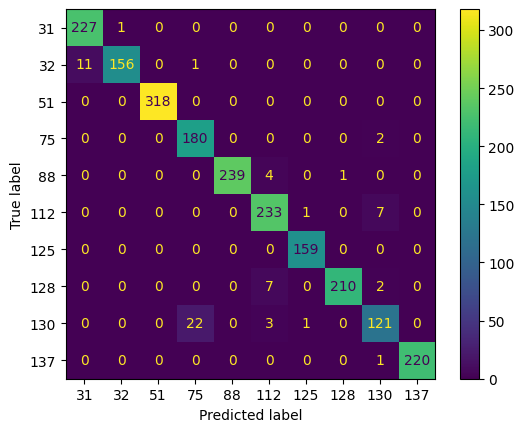

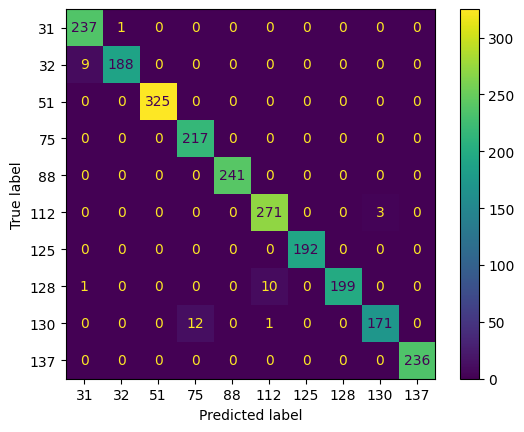

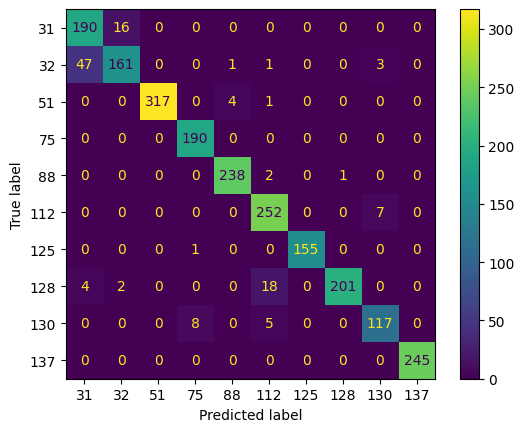

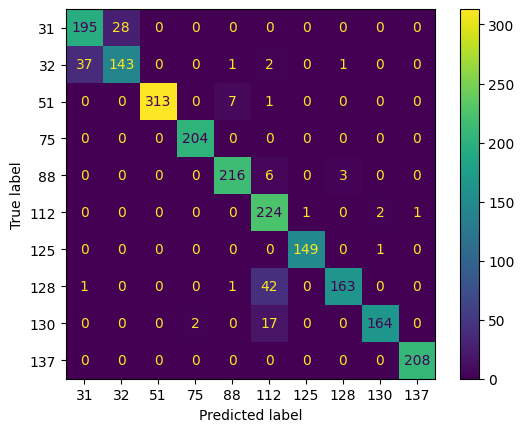

In [15]:
y_pred = clf_lr.predict(X_test)

print("Statistics for test set - Logistic Regression")
print(classification_report(y_test, y_pred))

relevant_test_idxs = np.where(np.isin(y_test, top_10_fruits) & np.isin(y_pred, top_10_fruits))[0]
ConfusionMatrixDisplay.from_predictions(y_test[relevant_test_idxs], y_pred[relevant_test_idxs])

y_pred = clf_svm.predict(X_test)

print("Statistics for test set - SVM")
print(classification_report(y_test, y_pred))

relevant_test_idxs = np.where(np.isin(y_test, top_10_fruits) & np.isin(y_pred, top_10_fruits))[0]
ConfusionMatrixDisplay.from_predictions(y_test[relevant_test_idxs], y_pred[relevant_test_idxs])

y_pred = clf_rf.predict(X_test)

print("Statistics for test set - Random Forest")
print(classification_report(y_test, y_pred))

relevant_test_idxs = np.where(np.isin(y_test, top_10_fruits) & np.isin(y_pred, top_10_fruits))[0]
ConfusionMatrixDisplay.from_predictions(y_test[relevant_test_idxs], y_pred[relevant_test_idxs])

y_pred = clf_xgb.predict(X_test)

print("Statistics for test set - XGBoost")
print(classification_report(y_test, y_pred))

relevant_test_idxs = np.where(np.isin(y_test, top_10_fruits) & np.isin(y_pred, top_10_fruits))[0]
ConfusionMatrixDisplay.from_predictions(y_test[relevant_test_idxs], y_pred[relevant_test_idxs])